In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

# K channels: current-voltage relationship (I-V)

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [66]:
data_folder = "data/K_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/K_channels


['data/K_channels/2024_06_08_0007.abf',
 'data/K_channels/2024_06_08_0013.abf',
 'data/K_channels/2024_06_08_0014.abf']

Choose which file you want to analyze and past the file name here:

In [67]:
# data_file = 'data/K_channels/2024_06_08_0007.abf'
# data_file = 'data/K_channels/2024_06_08_0014.abf'

data_file = 'data/K_channels/2024_06_08_0013.abf'


Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(11, 2, 25000)
sampling freq: 49999.99999999999 Hz


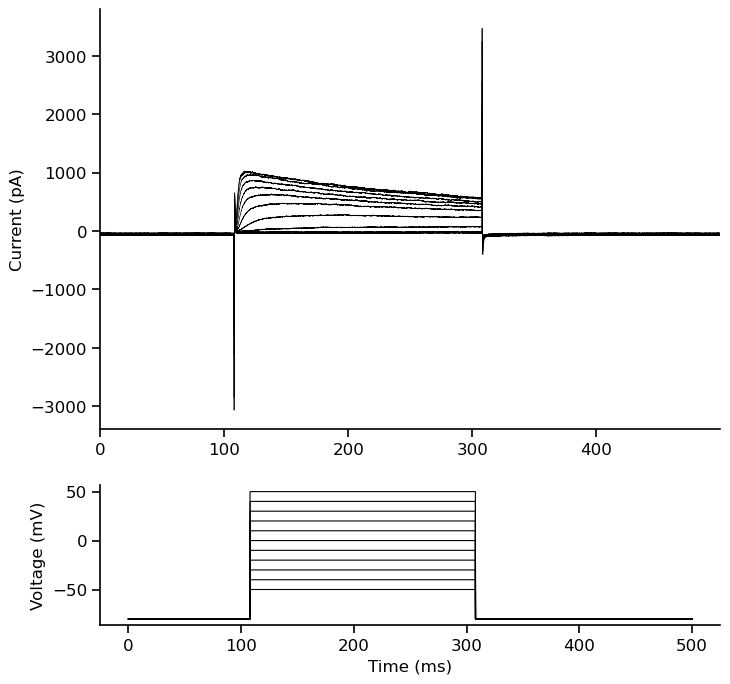

In [68]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

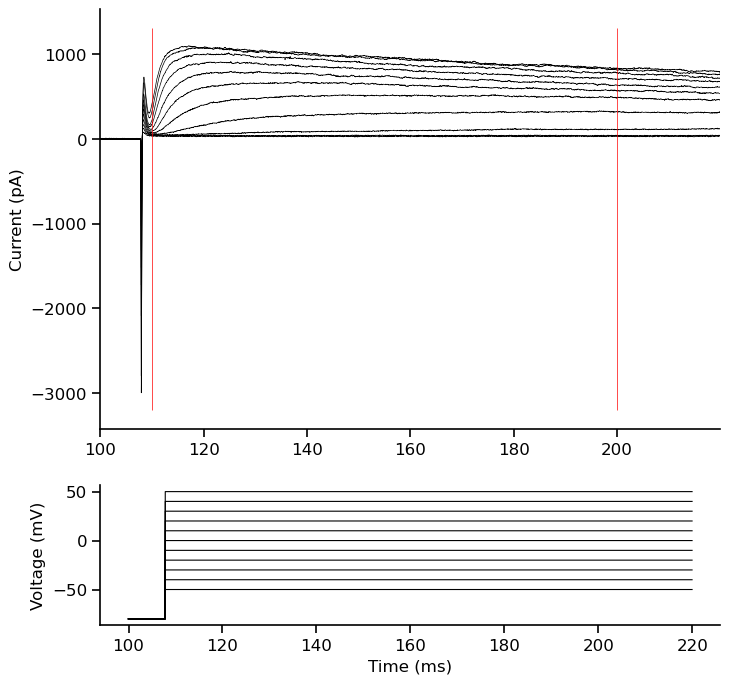

In [79]:
# The start/end time just helps to zoom in on the traces.
start_time = 100  # milliseconds
end_time = 220   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 110  # milliseconds
marker_2 = 200    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [78]:
# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_time = 0 # milliseconds
end_time = 100 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'

baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# Subtract baseline from the sweeps
num_traces = sweeps.shape[0]
for i in range(num_traces):
    sweeps[i,0] -= baseline_current[i]

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

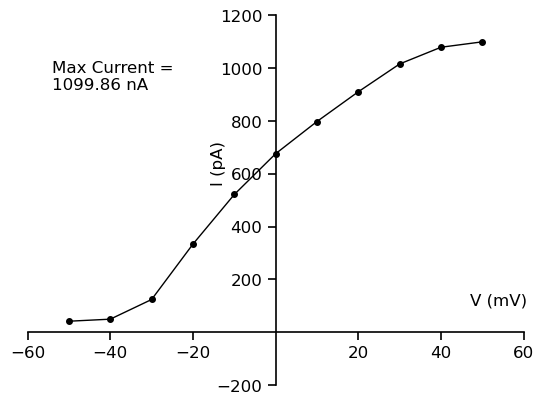

In [101]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                                     start_time=marker_1,
                                                     end_time=marker_2,
                                                     sampling_freq=sampling_freq,
                                                     measurement_type=measurement_type)

ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))

I_max = np.max(current_steps)
ax.text(0.05, 0.8, f'Max Current = \n{I_max:.2f} nA', transform=ax.transAxes)
plt.show()

### 3.4. Fit exponential curve to get the rise timeconstant

First let's define the relevant time window where we want to fit

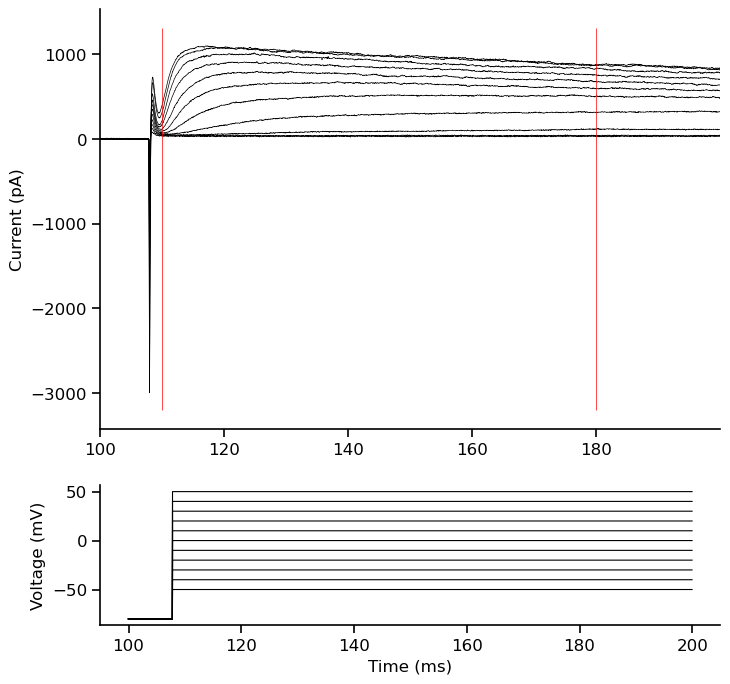

In [116]:
# The start/end time just helps to zoom in on the traces.
start_time = 100  # milliseconds
end_time = 200   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 110  # milliseconds
marker_2 = 180    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

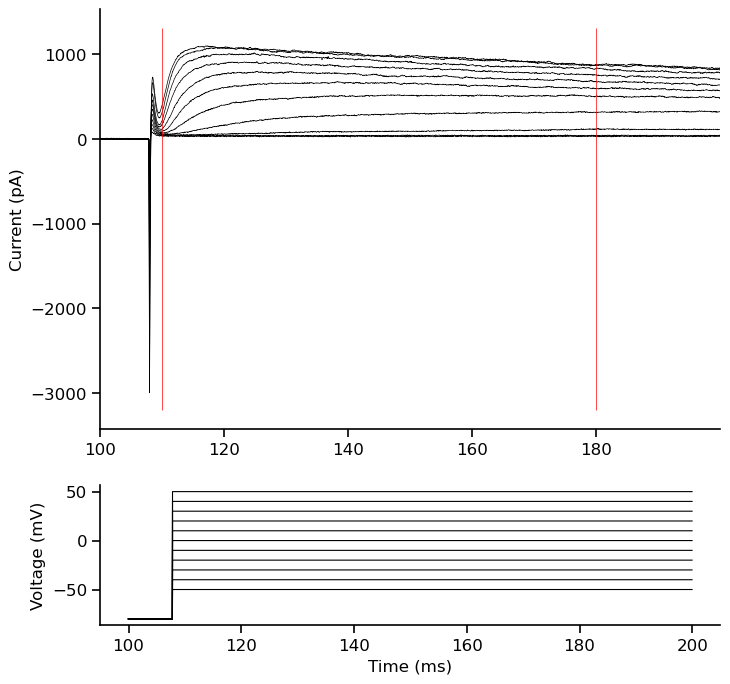

In [117]:
ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

# Get the peak value for each trace, and fit the exponential from the start to the peak
current_between_markers, time_in_window = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=0)

def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf

tau_values = []
for trace in current_between_markers:
    peak_value = np.max(trace)
    peak_index = np.argmax(trace)
    V0_guess = 0
    Vinf_guess = peak_value
    tau_guess = 1 # ms
    fit_params,_ = curve_fit(exponential_curve, time_in_window[0:peak_index], trace[0:peak_index], 
                             p0=[V0_guess, tau_guess, Vinf_guess], maxfev=2000)
    V0_fit, tau_fit, Vinf_fit = fit_params
    tau_values.append(tau_fit)
    
    # Overlay fit
    fit_trace = exponential_curve(time_in_window[0:peak_index], *fit_params)
    if ax is not None:
        ax[0].plot(time_in_window[0:peak_index], fit_trace, color='r', alpha=1, linewidth=2)


Text(0.5, 1.0, 'Tau Values for Each Sweep')

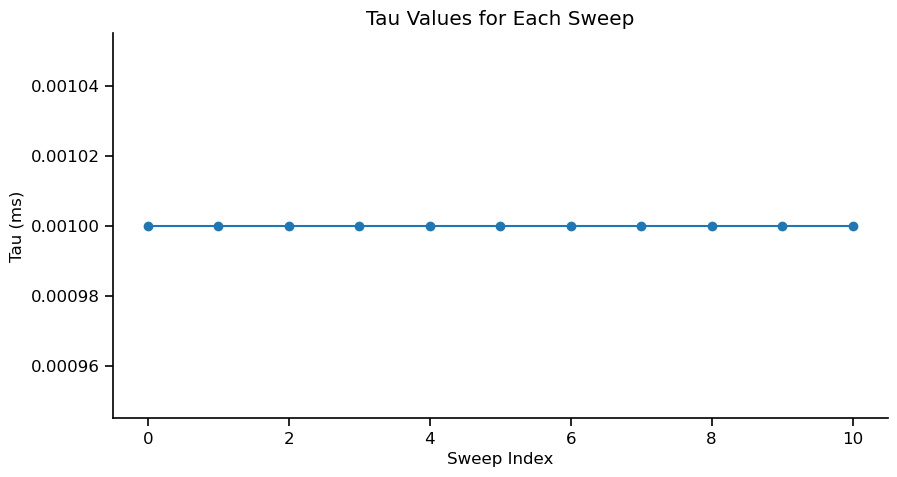

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tau_values, 'o-')
ax.set_xlabel('Sweep Index')
ax.set_ylabel('Tau (ms)')
ax.set_title('Tau Values for Each Sweep')